Import Dependencies

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras_preprocessing import image
from shutil import copyfile
from tensorflow.keras.applications.xception import preprocess_input

import matplotlib.pyplot as plt
import numpy as np
import os

Import Dataset

In [18]:
train_dir = 'New_Makanan/train/'
test_dir = 'New_Makanan/test/'
val_dir = 'New_Makanan/val/'

Split Dataset

In [19]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

generator = image.ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=45,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_images = generator.flow_from_directory(
    directory=train_dir, 
    class_mode='categorical', 
    color_mode='rgb',
    batch_size=BATCH_SIZE, 
    target_size=IMG_SIZE, 
    shuffle=True
)

test_images = generator.flow_from_directory(
    directory=test_dir, 
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE, 
    target_size=IMG_SIZE,
    shuffle=False
)

val_images = generator.flow_from_directory(
    directory=val_dir, 
    class_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE, 
    target_size=IMG_SIZE,
    shuffle=True
)

Found 3443 images belonging to 10 classes.
Found 981 images belonging to 10 classes.
Found 501 images belonging to 10 classes.


Use Transfer Learning (MobileNetV2)

In [20]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

base_model.trainable = False

Add More Layer

In [21]:
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


Training Model

In [22]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
history = model.fit(train_images,
                    epochs=20,
                    steps_per_epoch=len(train_images),
                    validation_data=val_images,
                    verbose = 1,
                    validation_steps=len(val_images))

Epoch 1/20
108/108 [==============================] - 106s 958ms/step - loss: 2.4598 - accuracy: 0.1502 - val_loss: 2.1022 - val_accuracy: 0.2455
Epoch 2/20
108/108 [==============================] - 126s 1s/step - loss: 2.0999 - accuracy: 0.2541 - val_loss: 1.8441 - val_accuracy: 0.3433
Epoch 3/20
108/108 [==============================] - 105s 972ms/step - loss: 1.8450 - accuracy: 0.3520 - val_loss: 1.6221 - val_accuracy: 0.4631
Epoch 4/20
108/108 [==============================] - 121s 1s/step - loss: 1.6640 - accuracy: 0.4310 - val_loss: 1.4680 - val_accuracy: 0.5130
Epoch 5/20
108/108 [==============================] - 125s 1s/step - loss: 1.5423 - accuracy: 0.4743 - val_loss: 1.3852 - val_accuracy: 0.5230
Epoch 6/20
108/108 [==============================] - 107s 989ms/step - loss: 1.4479 - accuracy: 0.5187 - val_loss: 1.2708 - val_accuracy: 0.5888
Epoch 7/20
108/108 [==============================] - 118s 1s/step - loss: 1.3405 - accuracy: 0.5606 - val_loss: 1.2045 - val_accurac

Training Results

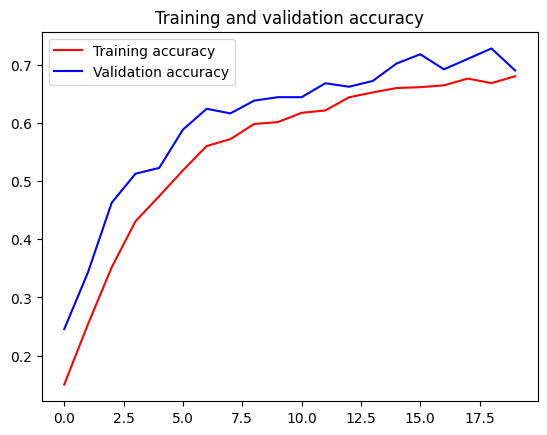

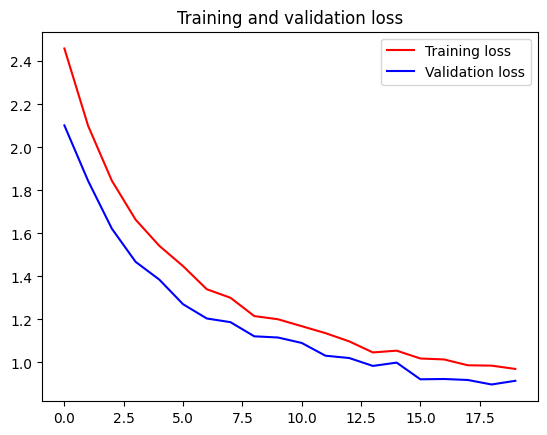

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
batch_size =20
test_score = model.evaluate_generator(test_images, batch_size)
print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

C:\Users\alfia\AppData\Local\Temp\ipykernel_20328\1991313292.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_score = model.evaluate_generator(test_images, batch_size)


[INFO] accuracy: 67.81%
[INFO] Loss:  0.9934532046318054


Save & Export the Model

In [27]:
model.save('checkpoint3/MobileNet.h5')

In [28]:
saved_model_path = 'checkpoint3'
model.save(saved_model_path)

INFO:tensorflow:Assets written to: checkpoint3\assets


INFO:tensorflow:Assets written to: checkpoint3\assets


Try the Model

In [9]:
from PIL import Image

model = tf.keras.models.load_model('checkpoint3/MobileNet.h5')

image_path = 'New_Makanan/test/gado gado/gado gado (75).jpg'
image = Image.open(image_path)
image = image.resize((224, 224))  
image = np.array(image) / 255.0 
image = np.expand_dims(image, axis=0)

predictions = model.predict(image)
predicted_class = np.argmax(predictions[0])

class_labels = ['Apem','Ayam Bakar', 'Bakso','Bakwan', 'Gado Gado','Gudeg','Lumpia','Pempek', 'Rendang', 'Sate']  # Replace with your own class labels

print("Predicted class:", class_labels[predicted_class])

1/1 [==============================] - 1s 766ms/step
Predicted class: Gado Gado


In [ ]:
Export to Tflite

In [29]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

with open(os.path.join('checkpoint3/', 'model_MobileNet.tflite'), 'wb') as f:
  f.write(tflite_model)

In [ ]:
import itertools

optimize_lite_model = False
representative_dataset = None
num_calibration_examples = 60
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)

if optimize_lite_model and num_calibration_examples:
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_images for image in batch),
      num_calibration_examples)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:
    converter.representative_dataset = representative_dataset
    
lite_model_content = converter.convert()

with open('checkpoint3/model_MobileNet.tflite', "wb") as f:
  f.write(lite_model_content)